C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Episode 0] Réwards: [1.208051776609983, 1.208051776609983], Epsilons: [0.995, 0.995]
[Episode 50] Réwards: [7.624938646221858, 7.624938646221858], Epsilons: [0.7744209942832988, 0.7744209942832988]


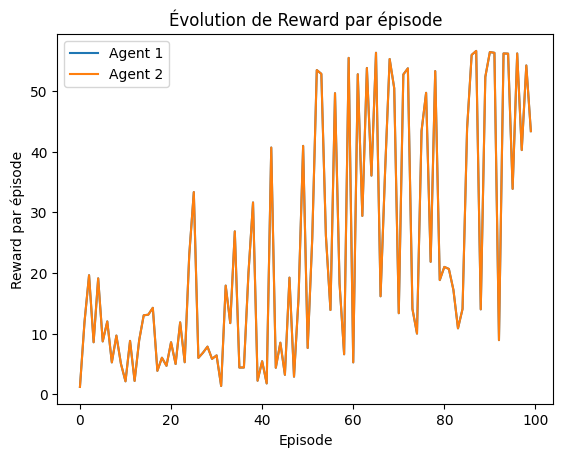

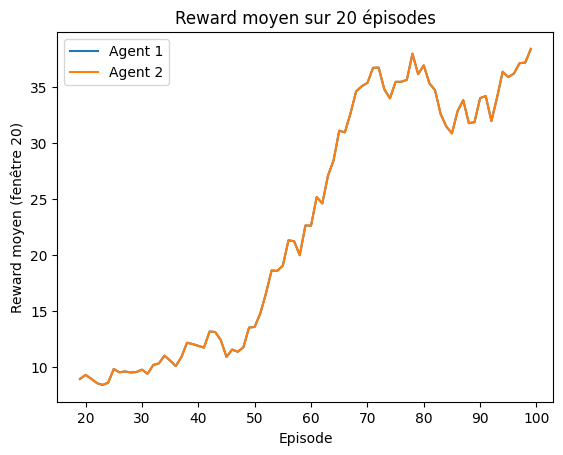

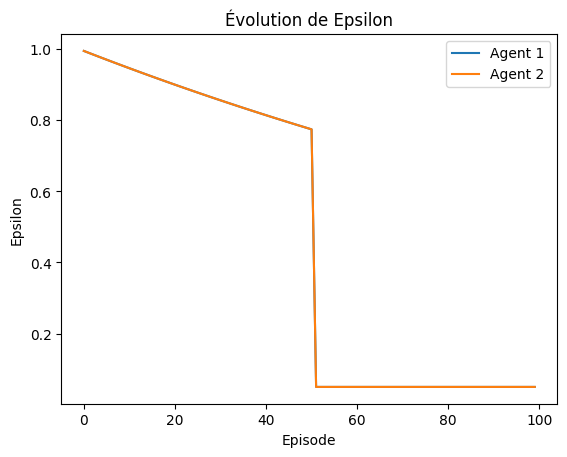

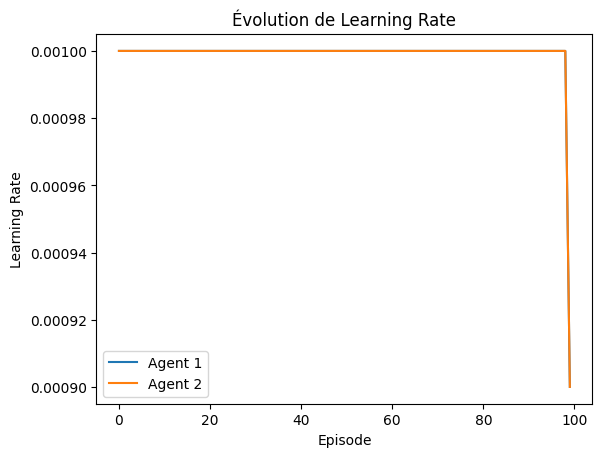

In [2]:
#!/usr/bin/env python3
"""
Multi-agent Double DQN sur l'environnement Highway-fast-v0 avec 2 véhicules contrôlés.
Affiche les courbes de reward, reward moyen, et évolution d'epsilon et du learning rate pour chaque agent.
"""

import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import highway_env

# --------------------------------------------------------------------------
# Chargement de la configuration de base (optionnel)
# --------------------------------------------------------------------------
with open("../config/1-highway-discrete-config.pkl", "rb") as f:
    base_config = pickle.load(f)

# --------------------------------------------------------------------------
# Création et configuration de l'environnement multi-agent
# --------------------------------------------------------------------------
env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.config.update(base_config)
# Configuration multi-agent et options de rendu
env.unwrapped.config.update({
    "controlled_vehicles": 2,
    # Pour pouvoir envoyer un tuple d'actions lors du step
    "action": {
        "type": "MultiAgentAction",
        "action_config": {"type": "DiscreteMetaAction"}
    },
    # Pour avoir un tuple d'observations par agent
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {"type": "Kinematics"}
    },
    # Ajustements graphiques : centrer la vue et échelle pour voir les deux véhicules simultanément
    "scaling": 7.5,
    "centering_position": [0.5, 0.5]
})
env.unwrapped.config.update(base_config)
env.unwrapped.config.update({
    "controlled_vehicles": 2,
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {"type": "Kinematics"}
    },
    "action": {
        "type": "MultiAgentAction",
        "action_config": {"type": "DiscreteMetaAction"}
    }
})
obs, info = env.reset(seed=0)

# --------------------------------------------------------------------------
# Fonctions d'aide (mêmes que pour l'agent simple)
# --------------------------------------------------------------------------
def is_risky(state):
    grid_range = base_config["observation"]["grid_size"][0]
    grid_step = base_config["observation"]["grid_step"][0]
    nx = int((grid_range[1] - grid_range[0]) / grid_step)
    ny = int((base_config["observation"]["grid_size"][1][1] - base_config["observation"]["grid_size"][1][0]) / base_config["observation"]["grid_step"][1])
    num_features = 7
    if state.size != nx * ny * num_features:
        return False
    grid = state.reshape(nx, ny, num_features)
    return np.any(grid[-1, :, 0] > 0.5)

def shape_reward(reward, action, state):
    shaped = reward
    if reward <= base_config.get("collision_reward", -1):
        shaped = reward * 2
    if action == 1 and is_risky(state):
        shaped -= 0.5
    return shaped

# --------------------------------------------------------------------------
# Réseau de neurones et agent DQN (Double DQN + masquage)
# --------------------------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)
        self.replay_buffer = deque(maxlen=100000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.action_dim = action_dim

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            acts = list(range(self.action_dim))
            if is_risky(state) and 1 in acts:
                acts.remove(1)
            return random.choice(acts) if acts else 1
        state_t = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.q_net(state_t).squeeze(0).numpy()
        if is_risky(state):
            q_vals[1] = -np.inf
        return int(np.argmax(q_vals))

    def update_epsilon(self, ep, total_ep):
        if ep > total_ep // 2:
            self.epsilon = self.epsilon_min
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        s  = torch.FloatTensor(s)
        a  = torch.LongTensor(a).unsqueeze(1)
        r  = torch.FloatTensor(r).unsqueeze(1)
        s2 = torch.FloatTensor(s2)
        d  = torch.FloatTensor(d).unsqueeze(1)

        q      = self.q_net(s).gather(1, a)
        with torch.no_grad():
            next_a = self.q_net(s2).argmax(dim=1, keepdim=True)
            q_next = self.target_net(s2).gather(1, next_a)
            target = r + self.gamma * (1 - d) * q_next

        loss = F.mse_loss(q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# --------------------------------------------------------------------------
# Entraînement multi-agent
# --------------------------------------------------------------------------
def train_multi_agents(agents, env, num_episodes=100, sync_target=10):
    rewards_hist = {i: [] for i in range(len(agents))}
    eps_hist     = {i: [] for i in range(len(agents))}
    lr_hist      = {i: [] for i in range(len(agents))}

    for ep in range(num_episodes):
        obs, info = env.reset()
        states = [o.flatten() for o in obs]
        ep_rewards = [0.0 for _ in agents]
        done = False

        while not done:
            actions = tuple(agent.get_action(s) for agent, s in zip(agents, states))
            next_obs, reward, term, trunc, infos = env.step(actions)
            # Répéter le même reward pour chaque agent
            rewards = [reward] * len(agents)
            done = term or trunc
            next_states = [no.flatten() for no in next_obs]

            for i, agent in enumerate(agents):
                sr = shape_reward(rewards[i], actions[i], states[i])
                agent.replay_buffer.append((states[i], actions[i], sr, next_states[i], float(done)))
                agent.update()
                ep_rewards[i] += rewards[i]

            states = next_states

        for i, agent in enumerate(agents):
            agent.update_epsilon(ep, num_episodes)
            agent.scheduler.step()
            rewards_hist[i].append(ep_rewards[i])
            eps_hist[i].append(agent.epsilon)
            lr_hist[i].append(agent.optimizer.param_groups[0]['lr'])

        if ep % sync_target == 0:
            for agent in agents:
                agent.target_net.load_state_dict(agent.q_net.state_dict())

        if ep % 50 == 0:
            print(f"[Episode {ep}] Réwards: {ep_rewards}, Epsilons: {[a.epsilon for a in agents]}")

    return rewards_hist, eps_hist, lr_hist

# --------------------------------------------------------------------------
# Visualisation
# --------------------------------------------------------------------------
def plot_agent_metrics(hist, label, window=20):
    plt.figure()
    for i, vals in hist.items():
        plt.plot(vals, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel(label)
    plt.legend()
    plt.title(f"Évolution de {label}")
    plt.show()

# --------------------------------------------------------------------------
# Exécution principale
# --------------------------------------------------------------------------
if __name__ == "__main__":
    state_dim = obs[0].flatten().shape[0]
    action_spaces = env.action_space.spaces if hasattr(env.action_space, 'spaces') else env.action_space
    action_dims = [space.n for space in action_spaces]

    agents = [DQNAgent(state_dim, ad) for ad in action_dims]
    rewards_hist, eps_hist, lr_hist = train_multi_agents(agents, env)

    # Affichage des courbes
    window = 20
    plot_agent_metrics(rewards_hist, "Reward par épisode")
    # Moyenne mobile
    for i, r in rewards_hist.items():
        mov = np.convolve(r, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(r)), mov, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel(f"Reward moyen (fenêtre {window})")
    plt.legend()
    plt.title("Reward moyen sur 20 épisodes")
    plt.show()

    plot_agent_metrics(eps_hist, "Epsilon")
    plot_agent_metrics(lr_hist, "Learning Rate")
